<a href="https://colab.research.google.com/github/Rockgecko/courses/blob/master/birdsong_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackday project to build a bird song classifier using Deep Learning (5/4/19)

## Step1: Acquiring bird song data files

In [0]:
import json 
import math
import requests
import shutil

country = "united kingdom"
#name = "troglodytes troglodytes" #wren
name = "erithacus rubecula" #robin
query_string = name

# nums of recordings to dl per query, leave 0 for all available, try 10 or 15 to test
numDls = 10 
# rate of print messages during dl            
alertRate = 2



In [0]:
url = "https://www.xeno-canto.org/api/2/recordings"
payload = {'query': query_string}
pageUrl = "&page="
recordings = []

session = requests.Session()

In [53]:
# check number of pages

r = session.get(server, params=payload)
data = r.json()
numRecordings = data['numRecordings']
numPages = math.ceil(int(data['numRecordings']) / 500)

print(f"number of available recordings: {int(data['numRecordings'])}")

del(data)   

number of available recordings: 2189


In [54]:
# get list of recordings

startPage = 1
maxnumPages=1
for page in range(startPage, min(maxnumPages+startPage,numPages+startPage)):
    payload["page"] = page
    r = session.get(server, params=payload)
    dataBuf = r.json()
    recordings += dataBuf['recordings']

del(dataBuf)
print(len(recordings))

500


In [0]:
# function to download a file
def download_file(url):
#    local_filename = url.split('/')[-1]
    filenameStart = url.find("/", 23)                                #Example : for given url "www.cs.berkeley.edu/~vazirani/algorithms/chap6.pdf" file_name will store "chap6.pdf"
    filenameEnd = url.find("/", 28)
    local_filename = url[filenameStart+1:filenameEnd] + ".mp3"
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    return local_filename

In [56]:
# Now download the audio files

names=[]
filePaths=[]

for i in range(len(recordings)):
    names.append(recordings[i]["en"])
    filePaths.append("http:" + recordings[i]["file"])
print("number of possible files to download: " + str(len(filePaths)))

if(numDls != 0):
    print("but only downloading : " + str(numDls))

#download a file
if(numDls == 0):
    numDls = len(recordings)

for dlUrl in range(numDls):
    if(dlUrl % alertRate == 0):
        print("downloading nr : " + str(dlUrl))
    local_file = download_file(filePaths[dlUrl])


print("Finished")

number of possible files to download: 500
but only downloading : 10
downloading nr : 0
downloading nr : 2
downloading nr : 4
downloading nr : 6
downloading nr : 8
Finished


In [0]:
# Used to store the labels for the audio files
#wren_files = [file[26:32] for file in filePaths[0:10]]
#robin_files = [file[26:32] for file in filePaths[0:10]]

In [0]:
#create files dataframe
full_data = pd.DataFrame()
i=0
for file in wren_files:
    filename = file + ".mp3"
    row_df = pd.DataFrame(data={"filename": filename, "label": "wren"}, index=[i])
    full_data = pd.concat([full_data, row_df], axis=0)
    i+=1
for file in robin_files:
    filename = file + ".mp3"
    row_df = pd.DataFrame(data={"filename": filename, "label": "robin"}, index=[i])
    full_data = pd.concat([full_data, row_df], axis=0)
    i+=1
    

In [70]:
display(full_data)

,filename,label
0,464850.mp3,wren
1,464367.mp3,wren
2,462908.mp3,wren
3,462699.mp3,wren
4,462617.mp3,wren
5,462392.mp3,wren
6,461839.mp3,wren
7,461075.mp3,wren
8,460064.mp3,wren
9,460061.mp3,wren


## Step 2: quick check of the audio files

In [0]:
%matplotlib inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import IPython.display as ipd



In [58]:
# can playback a file here

ipd.Audio(local_file)

In [0]:
# to load an audio file
data, sampling_rate = librosa.load(local_file, res_type='kaiser_fast')

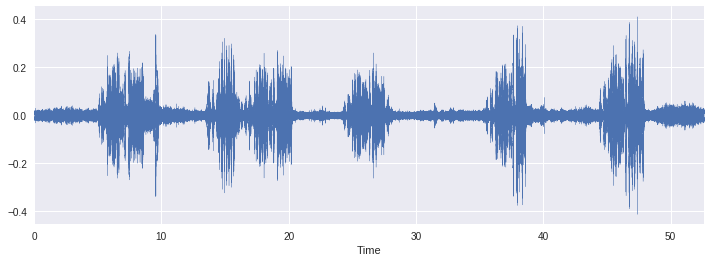

In [40]:
# to display an audio file
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [0]:
# to generate Mel-frequency cepstral coefficients (MFCCs)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T,axis=0) 

## Step 3: create test and training sets

In [0]:
# need to split into training and test (this is far too few files really, but this is just to get the process working)
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_data, test_size=0.2)

## Step 4: Load data and preprocess

In [0]:
def parser(row):
   # function to load files and extract features
   file_name = row["filename"]

   # handle exception to check if there isn't a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", file)
      return None, None
 
   feature = mfccs
   label = row.label
 
   return [feature, label]

temp = train.apply(parser, axis=1)
temp.columns = ['feature', 'label']

In [77]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

Using TensorFlow backend.


In [0]:
# prepare test data also
temp2 = test.apply(parser, axis=1)
temp2.columns = ['feature', 'label']

In [0]:
Xtest = np.array(temp2.feature.tolist())
ytest = np.array(temp2.label.tolist())

lb = LabelEncoder()

ytest = np_utils.to_categorical(lb.fit_transform(ytest))

## Step 5: Define and compile model

In [78]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics 

num_labels = y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Train Model

In [80]:
model.fit(X, y, batch_size=32, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
16/16 [==============================] - 1s 52ms/step - loss: 8.0590 - acc: 0.5000
Epoch 2/5
16/16 [==============================] - 0s 451us/step - loss: 10.0739 - acc: 0.3750
Epoch 3/5
16/16 [==============================] - 0s 553us/step - loss: 7.0517 - acc: 0.5625
Epoch 4/5
16/16 [==============================] - 0s 450us/step - loss: 9.7976 - acc: 0.3125
Epoch 5/5
16/16 [==============================] - 0s 394us/step - loss: 9.0664 - acc: 0.4375


## Step 6: Test Model

In [84]:
test_loss, test_accuracy = model.evaluate(Xtest, ytest)
print('Accuracy on test dataset:', test_accuracy)

4/4 [==============================] - 0s 14ms/step
Accuracy on test dataset: 0.75


In [0]:
predictions = model.predict(Xtest)

In [122]:
for prediction, yt in zip(predictions, ytest):
    predicted_label = np.argmax(predictions[1])
    true_label = np.argmax(yt)
    print(f"Predicted label: {lb.classes_[predicted_label]}; True label: {lb.classes_[true_label]}")


Predicted label: robin; True label: wren
Predicted label: robin; True label: robin
Predicted label: robin; True label: robin
Predicted label: robin; True label: robin
